In [1]:
import torch
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV


In [2]:
full_df = pd.read_csv('../data_full/full_dataset.csv')
full_y = full_df[['Ids']].to_numpy()
full_X = full_df[['W','L','T','Vgs','Vds']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(full_X, full_y, test_size=0.2)
xgb_model = xgboost.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': np.arange(0.01, 0.11, 0.01).tolist(), #so called `eta` value
              'max_depth': list(range(10, 100, 20)),
              'min_child_weight': list(range(5, 25, 5)),
              'silent': list(range(1,10, 2)),
              'subsample': np.arange(0.1,1,0.1).tolist(),
              'colsample_bytree': np.arange(0.1,1,0.1).tolist(),
              'n_estimators': list(range(100, 1100, 100))}

xgb_grid = GridSearchCV(xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

print(len(X_train), len(X_test))
xgb_grid.fit(X_train,y_train)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

69465 17367
Fitting 2 folds for each of 810000 candidates, totalling 1620000 fits
[00:17:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:41] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:17:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:41] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an is

In [ ]:
xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7, learning_rate=0.07, max_depth=5, min_child_weight=4, n_estimators=500, nthread=4, objective='reg:linear', silent=1, subsample=0.7)
xgb_model.fit(X_train, y_train)

[23:15:36] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[23:15:36] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=4,
             nthread=4, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

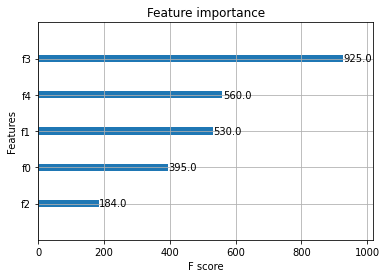

In [ ]:
xgboost.plot_importance(xgb_model)

In [ ]:
predictions = xgb_model.predict(X_test)
predictions

array([ 2.8025746e-04, -5.6714343e-05,  7.4859687e-05, ...,
        2.2203817e-04,  2.9858829e-05,  9.3516355e-06], dtype=float32)

In [ ]:
y_test.flatten()

array([3.2616e-04, 7.6675e-14, 7.6665e-12, ..., 1.8147e-04, 1.5020e-13,
       4.4795e-06])

In [ ]:
r_sq = xgb_model.score(X_train, y_train)
print(r_sq)
print(explained_variance_score(predictions,y_test))

0.9749274487463591
0.9668517640866497


In [ ]:
def NRMSELoss(y_hat, y, eps=1e-8):
    log_abs_y_hat = torch.log(torch.abs(y_hat)+eps)
    log_abs_y = torch.log(torch.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = y_hat.size(dim=0)
    return torch.sqrt((1/len_delta)*torch.sum((log_abs_delta/(log_abs_y+eps))**2)) + torch.sqrt((1/len_delta)*torch.sum((delta/(y+eps))**2))

In [ ]:
predictions = torch.tensor(xgb_model.predict(X_test))
actuals = torch.tensor(y_test.flatten())
nrmse = NRMSELoss(predictions, actuals)
print(nrmse)
    

tensor(10468.2005, dtype=torch.float64)
